In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import seaborn as sns
import os

import cv2

from glob import glob
from matplotlib.patches import  Polygon
from matplotlib.collections import PatchCollection
from scipy.stats import linregress
from scipy.spatial.distance import cdist


from utils import geometry

In [2]:
def make_polygon(i, C, R, cell_centres):
    """
    Generate polygon

    Parameters:
    i (int): cell id
    C (numpy array): Nc x Nv order array relating cells to vertices
    R (numpy array): vertex coordinates
    cell_centres (numpy array): cell centre coordinates
    """

    Ralpha=R[np.where(C[i,:]==1)[0]]-cell_centres[i] #ref frame of cell
    ang=np.arctan2(Ralpha[:,1], Ralpha[:,0])%(2*np.pi) #find angle with x axis
    R_ang=np.transpose(np.vstack((np.where(C[i,:]==1)[0], ang))) #stack index of vertices with angle
    ordered_vertices=R_ang[np.argsort(R_ang[:,-1], axis=0)] #sort by anticlockwise angle
    polygon = Polygon(R[ordered_vertices[:,0].astype(int)],closed = True)
    return polygon

def plot_edges(A, R):
    N_e=np.shape(A)[0]
    beg_edge = ((abs(A) - A)*0.5)@R
    end_edge = ((abs(A) + A)*0.5)@R
    for j in range(0,N_e):
        if (beg_edge[j,0]!=0) and (end_edge[j, 0]!=0):
            plt.plot([beg_edge[j,0],end_edge[j,0]],[beg_edge[j,1],end_edge[j,1]],'k',alpha=1.0,linestyle ='-')

def plot_cell_centres(cell_centres):
    for i in range(len(cell_centres)):
        plt.plot(cell_centres[i,0],cell_centres[i,1],'k',marker ='o',markersize=1)
        
def plot_cell_id(cell_centres):
    for i in range(len(cell_centres)):
        plt.text(cell_centres[i][0], cell_centres[i][1], str(i),fontsize= 7,color='w', horizontalalignment='center', verticalalignment='center')

def plot_alignment_axis(cell_centres,alignment_axis):
    for i in range(len(cell_centres)):
            plt.quiver(cell_centres[i,0],cell_centres[i,1],np.cos(alignment_axis)[i],np.sin(alignment_axis)[i],facecolor = 'black',scale=110,width=0.002,headwidth=0.0,headlength=0.0,headaxislength=0.0)
            plt.quiver(cell_centres[i,0],cell_centres[i,1],-np.cos(alignment_axis)[i],-np.sin(alignment_axis)[i],facecolor = 'black',scale=110,width=0.002,headwidth=0.0,headlength=0.0,headaxislength=0.0)



def plot_polys(C, R, cell_centres):
    N_c=np.shape(C)[0]
    patches = []

    for i in range(N_c):
        polygon = make_polygon(i, C, R, cell_centres)
        patches.append(polygon)

    p = PatchCollection(patches,alpha = 1.0)
    return p

def plot_binary_polys(C, R, cell_centres, plot_var, threshold):
    N_c=np.shape(C)[0]
    patches = []
    patchesLow = []
    patchesHigh = []

    for i in range(N_c):
        polygon = make_polygon(i, C, R, cell_centres)
        patches.append(polygon)
        
        if plot_var[i] < threshold:
            polygonLow = polygon
            patchesLow.append(polygonLow)
        else:
            polygonHigh = polygon
            patchesHigh.append(polygonHigh)


    ### For binary effective pressure
    p_low = PatchCollection(patchesLow,alpha = 0.5)
    p_high = PatchCollection(patchesHigh,alpha = 0.7)
   
    return p_low, p_high


In [5]:
pixel_size=1024
micron_size=276.92


data_dir='C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Relaxation\\20210527_1_uf\\Data/'
plot_dir='C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Relaxation\\20210527_1_uf\\Plots/'
#files_i=sorted(glob(data_dir+'20210527_1_uf__fr*_cell_data_all_Gamma_0.172_Lambda_-0.259.csv'))
files_s=sorted(glob(data_dir+'20210527_1_uf_*_fr*_cell_data_all_Gamma_0.172_Lambda_-0.259.csv'))
df=pd.read_csv(files_s[0])
df['frame']=1
df['time']=0
df['area_norm']=df.cell_area_microns.div(df[df.time==0].cell_area_microns, axis=0)
df['perimeter_norm']=df.cell_perimeter_microns.div(df[df.time==0].cell_perimeter_microns, axis=0)
df['shear_strain']=(df.cell_perimeter_microns/df.cell_area_microns) * df.cell_zeta
df['area_change_norm']=(df.cell_area_microns-df[df.time==0].cell_area_microns).div(df[df.time==0].cell_area_microns, axis=0)
df['area_change']=(df.cell_area_microns-df[df.time==0].cell_area_microns)
df['angle_horizontal']=abs(np.where(df[df.time==0].major_shape_axis_alignment_rads<np.pi/2,df[df.time==0].major_shape_axis_alignment_rads, df[df.time==0].major_shape_axis_alignment_rads-np.pi))
i=1
for f in files_s[1:]:
    data_s=pd.read_csv(f)
    data_s['frame']=int(f.split('\\')[-1].split('_')[4][2:])
    data_s['time']=(i+4)*60
    data_s['area_norm']=data_s.cell_area_microns.div(df[df.time==0].cell_area_microns, axis=0)
    data_s['perimeter_norm']=data_s.cell_perimeter_microns.div(df[df.time==0].cell_perimeter_microns, axis=0)
    data_s['shear_strain']=(data_s.cell_perimeter_microns/data_s.cell_area_microns) * data_s.cell_zeta
    data_s['area_change']=(data_s.cell_area_microns-df[df.time==0].cell_area_microns)
    data_s['area_change_norm']=(data_s.cell_area_microns-df[df.time==0].cell_area_microns).div(df[df.time==0].cell_area_microns, axis=0)
    data_s['angle_horizontal']=abs(np.where(data_s.major_shape_axis_alignment_rads<np.pi/2,data_s.major_shape_axis_alignment_rads, data_s.major_shape_axis_alignment_rads-np.pi))
    df=pd.concat([df, data_s], ignore_index=True)
    i+=5

df.to_csv(data_dir+'20210527_1_collated.csv')

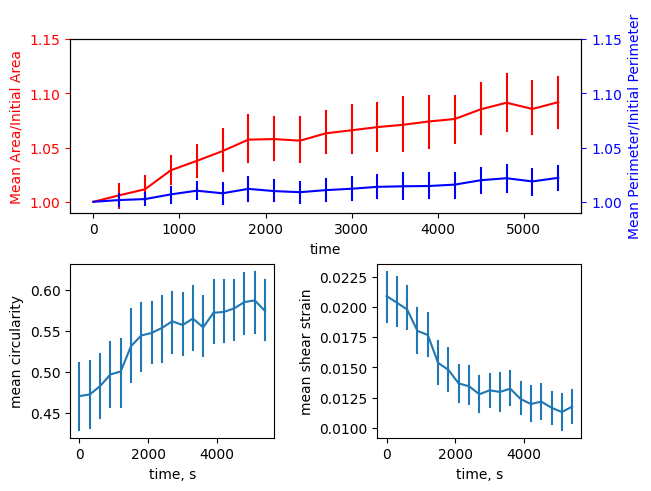

In [8]:
from matplotlib.gridspec import GridSpec
fig = plt.figure(layout="constrained")

gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
# identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

ax11 = ax1.twinx()
sns.lineplot(data=df, x="time", y="area_norm", err_style='bars', errorbar='ci', ax=ax1, c='red')
sns.lineplot(data=df, x="time", y="perimeter_norm", err_style='bars', errorbar='ci', ax=ax11, c='blue')
ax1.tick_params(axis='y', colors='red')
ax11.tick_params(axis='y', colors='blue')
ax1.set_ylim(0.99,1.15)
ax11.set_ylim(0.99,1.15)
ax11.set(ylabel="Mean Perimeter/Initial Perimeter")
ax1.set(ylabel="Mean Area/Initial Area")
ax1.yaxis.label.set_color('red')
ax11.yaxis.label.set_color('blue')


sns.lineplot(data=df, x="time", y="circularity", err_style='bars', errorbar='ci',ax=ax2)
sns.lineplot(data=df, x="time", y="shear_strain", err_style='bars', errorbar='ci', ax=ax3)
ax2.set_xlabel("time, s")
ax2.set_ylabel("mean circularity")
ax3.set_xlabel("time, s")
ax3.set_ylabel("mean shear strain")



fig.suptitle(" ")


plt.savefig(plot_dir+'/shape_line_all.png', dpi=300, bbox_inches='tight')

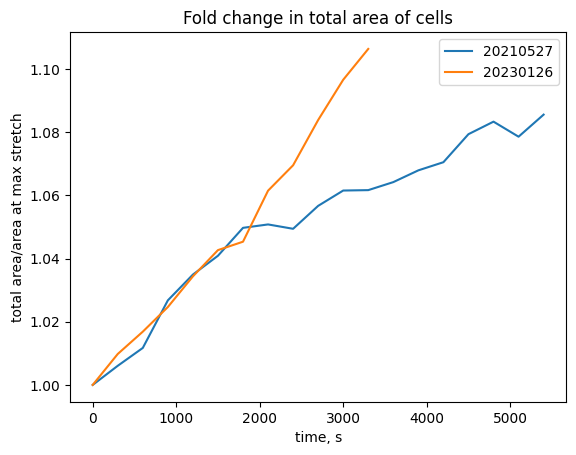

In [60]:
t=np.linspace(0, 5400, 19)
plt.plot(t,df.groupby('time').sum().cell_area_microns/df.groupby('time').sum().cell_area_microns[0], label='20210527')
plt.plot(t_uf_a, uf_a_tot_area, label='20230126')
plt.legend()
plt.xlabel("time, s")
plt.ylabel("total area/area at max stretch")
plt.title("Fold change in total area of cells")
plt.savefig(plot_dir+'/total_area_uf_a_b.png', dpi=300, bbox_inches='tight')

In [63]:
df[df.time==0].count()

cell_id                             65
cell_perimeter_microns              65
cell_area_microns                   65
cell_perimeter_nd                   65
cell_area_nd                        65
cell_P_eff_nd                       65
shape_parameter                     65
circularity                         65
cell_edge_count                     65
cell_shear                          65
cell_zeta                           65
major_shape_axis_alignment_rads     65
major_stress_axis_alignment_rads    65
frame                               65
time                                65
area_norm                           65
perimeter_norm                      65
shear_strain                        65
area_change_norm                    65
area_change                         65
angle_horizontal                    65
dtype: int64

In [58]:
uf_a_tot_area=[1.        , 1.00979926, 1.01686604, 1.02466651, 1.0343717 ,
       1.04268856, 1.0453533 , 1.06151483, 1.06955891, 1.08388908,
       1.09663432, 1.10640159]
t_uf_a= np.linspace(0, 3300, 12)
t_uf_a

array([   0.,  300.,  600.,  900., 1200., 1500., 1800., 2100., 2400.,
       2700., 3000., 3300.])

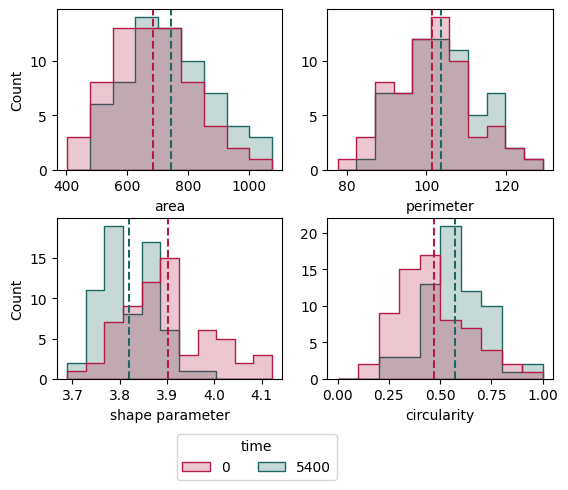

In [14]:
fig, ax=plt.subplots(2,2)
g=sns.histplot(data=df[(df.time ==0) | (df.time==5400)], hue='time',x='cell_area_microns', element="step", palette=sns.husl_palette(2,l=.4), ax=ax[0,0])
ax[0,0].axvline(np.mean(df[df.time ==0].cell_area_microns), c=sns.husl_palette(2,l=.4)[0], linestyle='--')
ax[0,0].axvline(np.mean(df[df.time ==5400].cell_area_microns), c=sns.husl_palette(2,l=.4)[1], linestyle='--')


sns.histplot(data=df[(df.time ==0) | (df.time==5400)], hue='time',x='cell_perimeter_microns', element="step",legend=False, palette=sns.husl_palette(2,l=.4), ax=ax[0,1])
ax[0,1].axvline(np.mean(df[df.time ==0].cell_perimeter_microns), c=sns.husl_palette(2,l=.4)[0], linestyle='--')
ax[0,1].axvline(np.mean(df[df.time ==5400].cell_perimeter_microns), c=sns.husl_palette(2,l=.4)[1], linestyle='--')


sns.histplot(data=df[(df.time ==0) | (df.time==5400)], hue='time',x='circularity', element="step", legend=False, palette=sns.husl_palette(2,l=.4), ax=ax[1,1], binrange=[0,1], bins=10)
ax[1,1].axvline(np.mean(df[df.time ==0].circularity), c=sns.husl_palette(2,l=.4)[0], linestyle='--')
ax[1,1].axvline(np.mean(df[df.time ==5400].circularity), c=sns.husl_palette(2,l=.4)[1], linestyle='--')


sns.histplot(data=df[(df.time ==0) | (df.time==5400)], hue='time',x='shape_parameter', element="step", legend=False, palette=sns.husl_palette(2,l=.4), ax=ax[1,0])
ax[1,0].axvline(np.mean(df[df.time ==0].shape_parameter), c=sns.husl_palette(2,l=.4)[0], linestyle='--')
ax[1,0].axvline(np.mean(df[df.time ==5400].shape_parameter), c=sns.husl_palette(2,l=.4)[1], linestyle='--')


plt.subplots_adjust(hspace=0.3)
ax[0,1].set_ylabel('')
ax[1,1].set_ylabel('')

ax[0,1].set_xlabel('perimeter')
ax[1,1].set_xlabel('circularity')
ax[1,0].set_xlabel('shape parameter')
ax[0,0].set_xlabel('area')
sns.move_legend(g, "upper left", bbox_to_anchor=(0.5, -1.6), frameon=True, ncol=3)
plt.savefig(plot_dir+'/shape_hists_all.png', dpi=300, bbox_inches='tight')

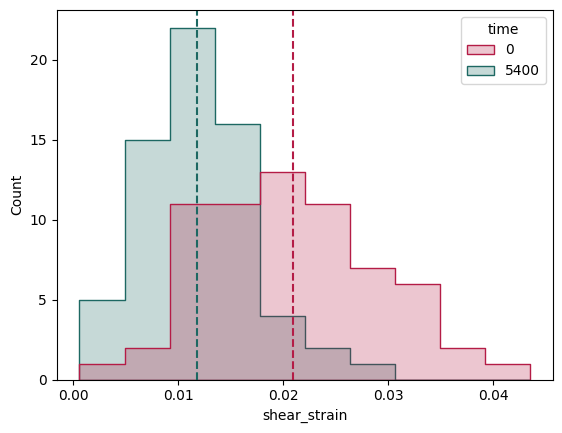

In [15]:
sns.histplot(data=df[(df.time ==0) | (df.time==5400)], hue='time',x='shear_strain', element="step", palette=sns.husl_palette(2,l=.4))
plt.axvline(np.mean(df[df.time ==0].shear_strain), c=sns.husl_palette(2,l=.4)[0], linestyle='--')
plt.axvline(np.mean(df[df.time ==5400].shear_strain), c=sns.husl_palette(2,l=.4)[1], linestyle='--')
plt.xlabel('shear_strain')
plt.savefig(plot_dir+'/shear_strain.png', dpi=300)

([<matplotlib.axis.YTick at 0x1bd78f65600>,
 [Text(0, 0.0, '0'),
  Text(0, 0.7853981633974483, '$\\frac{\\pi}{4}$'),
  Text(0, 1.5707963267948966, '$\\frac{\\pi}{2}$')])

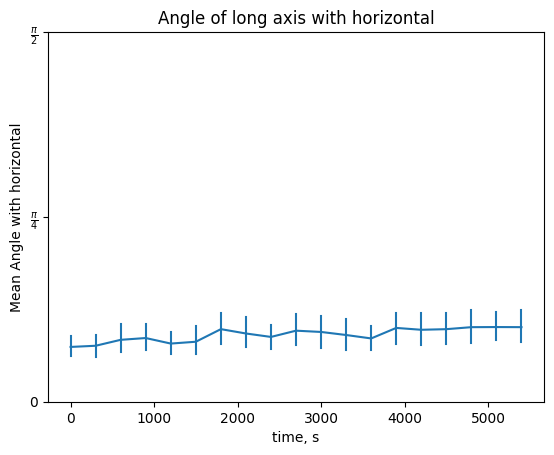

In [17]:
sns.lineplot(data=df, x='time', y='angle_horizontal', errorbar='ci', err_style='bars')
plt.ylabel("Mean Angle with horizontal")
plt.xlabel("time, s")
plt.title("Angle of long axis with horizontal")
plt.ylim(0, 90/180*np.pi)
plt.yticks(np.linspace(0, 90/180*np.pi, 3),[0,'$\\frac{\pi}{4}$','$\\frac{\pi}{2}$'])

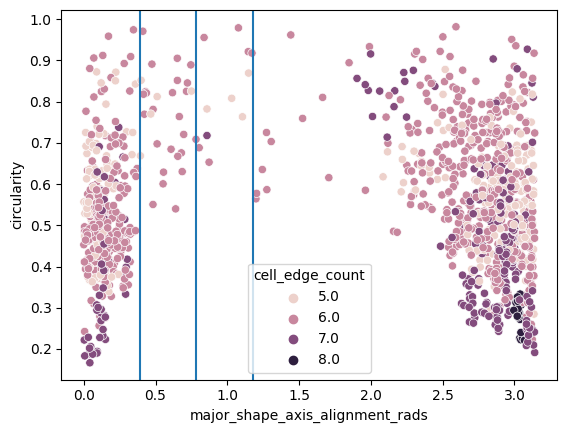

In [20]:
sns.scatterplot(data=df, x='major_shape_axis_alignment_rads', hue='cell_edge_count', y='circularity')
plt.axvline(np.pi/4)
plt.axvline(np.pi/8)
plt.axvline(3*np.pi/8)

<AxesSubplot: xlabel='time', ylabel='angle_horizontal'>

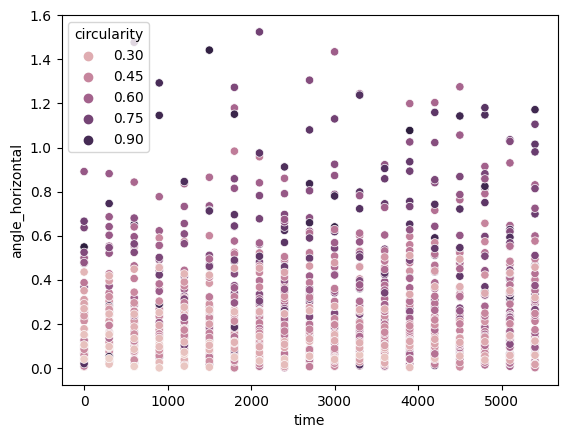

In [24]:
sns.scatterplot(data=df, x='time', y='angle_horizontal', hue='circularity')

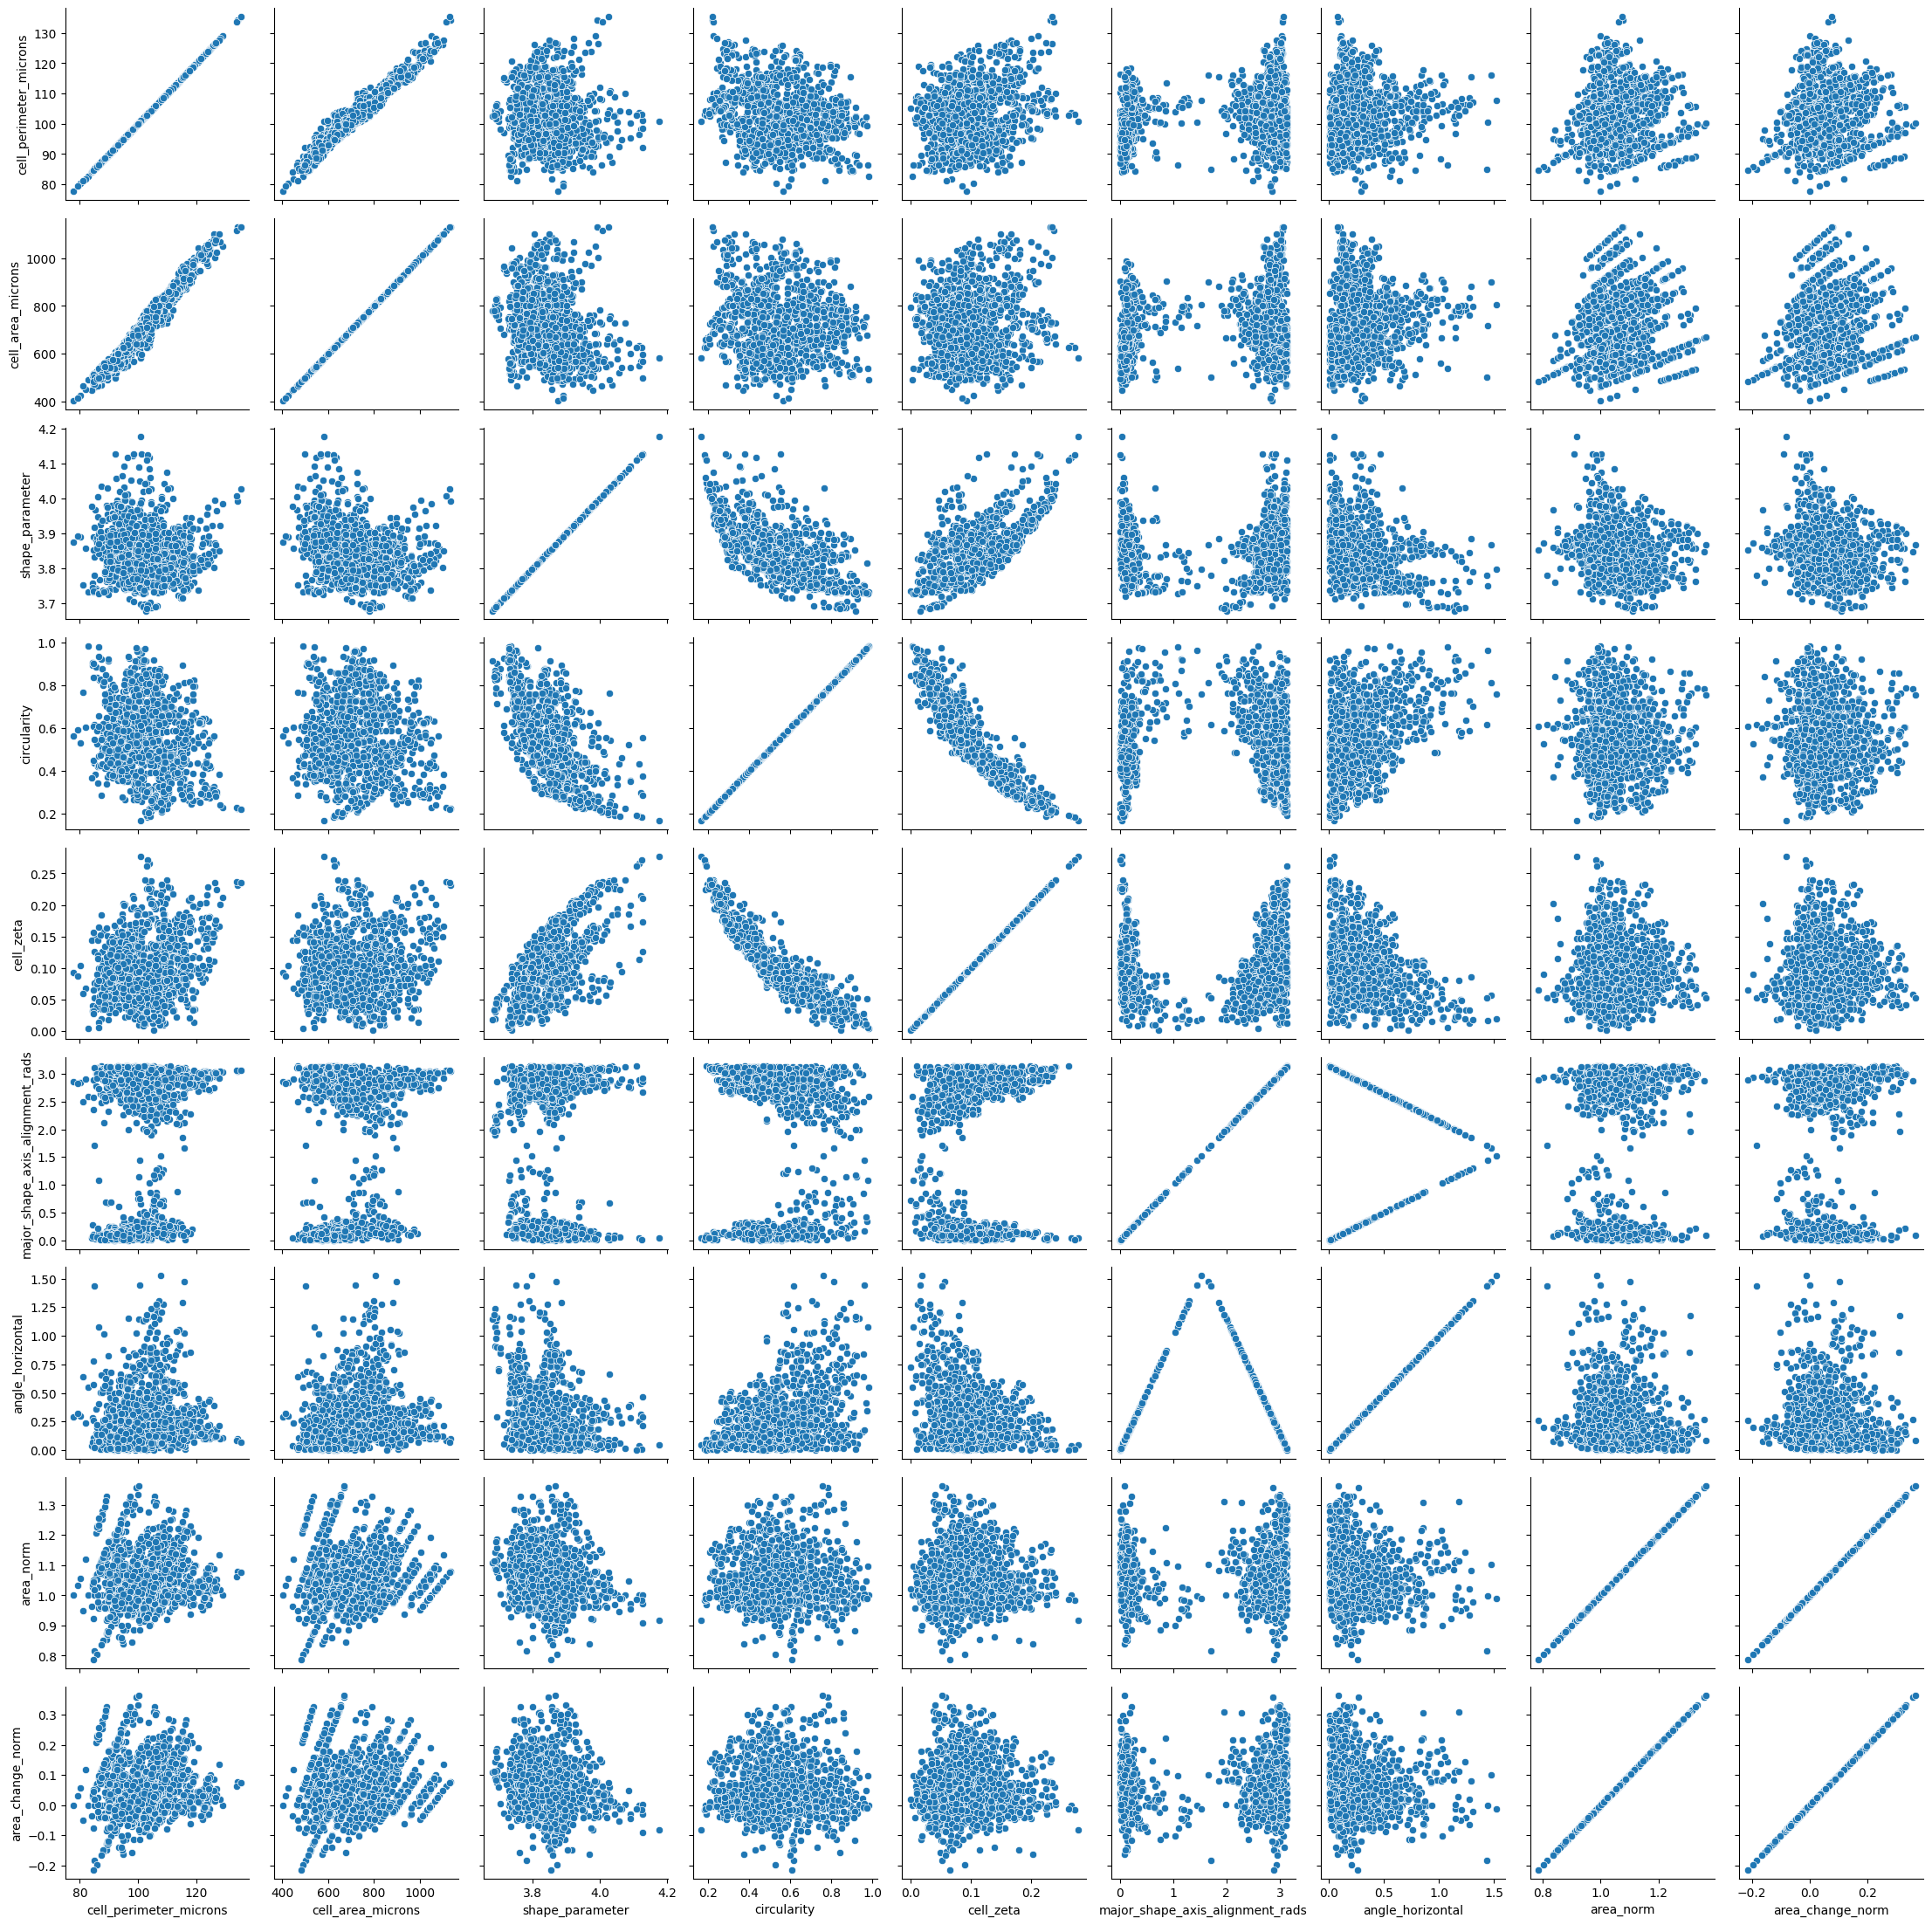

In [53]:
df_pp=df[[ 'cell_perimeter_microns', 'cell_area_microns', 'shape_parameter',
       'circularity',  'cell_zeta',
       'major_shape_axis_alignment_rads', 'angle_horizontal', 'area_norm', 'area_change_norm']]
g = sns.PairGrid(df_pp)
g.map(sns.scatterplot)

<AxesSubplot: xlabel='angle_horizontal', ylabel='circularity'>

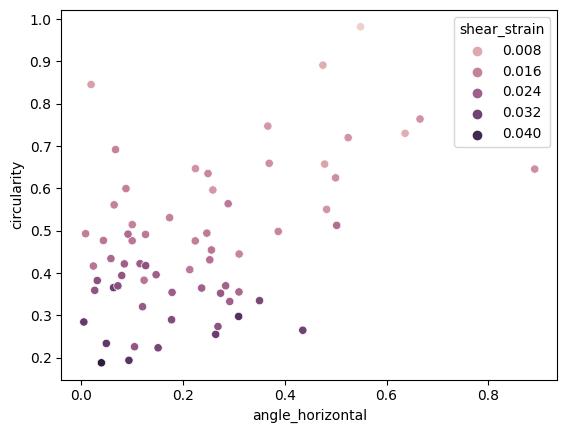

In [52]:
sns.scatterplot(data=df[df.time==0], y='circularity', x='angle_horizontal', hue='shear_strain')

<AxesSubplot: xlabel='time', ylabel='shape_parameter'>

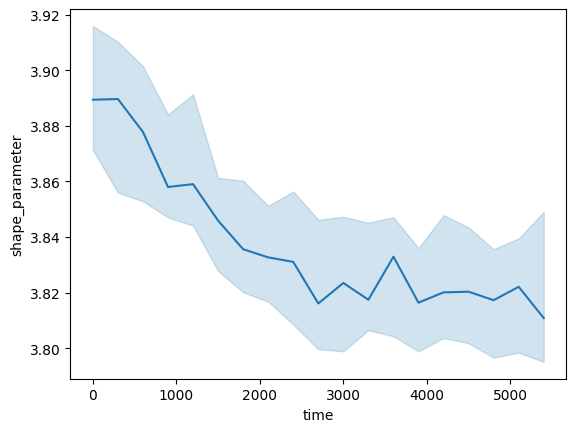

In [66]:
sns.lineplot(data=df, x='time', y='shape_parameter', estimator=np.median)

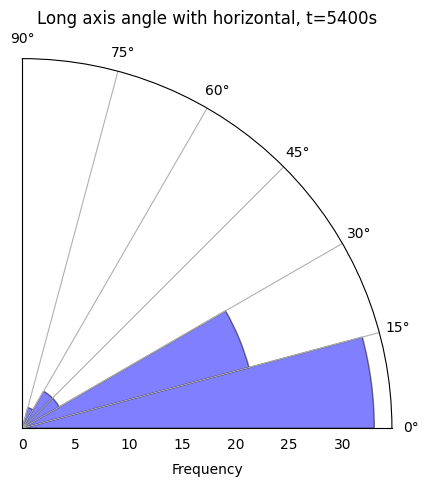

In [57]:
    bins = np.linspace(0.0, 90/180 *np.pi,7)

    #angle=rotate_angle_0

    n, _, _ = plt.hist(df[df.time==5400].angle_horizontal,range=[0,np.pi/2], bins=6)

    plt.clf()
    width = np.pi/2 /6
    ax = plt.subplot(1, 1, 1, projection='polar')
    bars = ax.bar(bins[:6], n, width=width, bottom=0, align='edge',color='blue', edgecolor='k')
    for bar in bars:
        bar.set_alpha(0.5)
        
    ax.set_xticks(bins)
    ax.set_thetamin(0)
    ax.set_thetamax(90)
    ax.yaxis.grid(False)
    ax.set_xlabel('Frequency')
    ax.set_title('Long axis angle with horizontal, t=5400s')
    ax.xaxis.labelpad=20
    plt.savefig(plot_dir+'/angle_5400.png', dpi=300, bbox_inches='tight')